<h1>Kmeans Clustering</h1>
<img src="https://github.com/asyz8/pytorch_tutorials/blob/main/section02_pytorch_basics/data/K_means.gif?raw=1" width="1000" align="center">
With our knowledge of Python and now Numpy lets create an implementation of a famous machine learning algorithm "K-Means Clustering". The job of a clustering algorithm is to break a dataset into some number of "clusters" (groups), the number of clusters usually defined by the user. K-Means clustering working by iteratively updating  a pre-defined number of cluster centers. It does this by finding the distance between each datapoint and every cluster center. Datapoints are then assigned to the cluster center they are closest to and each cluster center is updated to be the mean of the new cluster. These steps are updated for some number of steps or until the cluster centers converge (they stop moving so much)<br>
<b>Lets have a look at the steps of K-means clustering</b><br>
1. Define the number of clusters "k" you want to group your data into<br>
2. Randomly initialise k vectors with the same size as each datapoint, this is the initialisation of our cluster centers<br>
3. Calculate the distance between each datapoint and each cluster center (using MSE or equivalent)<br>
4. For every datapoint find the cluster center they are closest to<br>
5. Re-calculate the cluster centers by finding the mean of every new cluster<br>
6. Repeat steps 3-6 for n steps or until convergence

In [8]:
import urllib.request
import gzip
import pickle
import os
import numpy as np

from PIL import Image

def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return
    else:
        os.makedirs(dataset_dir, exist_ok=True)

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

def download_mnist():
    for v in key_file.values():
        _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """
    Parameters
    ----------
    normalize : Normalize the pixel values
    flatten : Flatten the images as one array
    one_hot_label : Encode the labels as a one-hot array

    Returns
    -------
    (Trainig Image, Training Label), (Test Image, Test Label)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()


# Load the MNIST dataset
url_base = 'https://ossci-datasets.s3.amazonaws.com/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = "datasets/MNIST/raw"
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

(train_x, train_y), (test_x, test_y) = load_mnist(normalize=False, flatten=True)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from IPython.display import clear_output

<b>Using the module "load" that comes with this notebook, lets load our dataset</b><br>
The dataset we'll be using is the MNIST dataset, a dataset of small, low-res handwritten digits. There are 60000 training images and 10000 test images divided up into 10 classes (digits 0-9). Here we will be using the test set (as it's a smaller set)

In [10]:
#Number of datapoint
num_img = 10000
#Number of cluster centers, 10 because the dataset contains 10 classes eg: digit 0 to 9
num_means = 10
#We'll perform this many iterations of the algorithm
iterations = 20
#Each image is 28*28 pixels, which has been flattened to a vector 0f 784 values
data_size = 28*28
# The images are 8 bit greyscale images (values range from 0-255)
# We'll rescale the pixel values to be between 0-1 (We don't REALLY need to do this for k-means)
test_x_tensor = torch.Tensor((test_x.astype(float) / 255))

In [11]:
test_x_tensor.shape

torch.Size([10000, 784])

<h3> Kmeans Initialization </h3>
Here we'll initialise the cluster centers to random values by creating a 10*784 matrix (2D Tensor) by randomly sampling 10 points from the dataset

In [19]:
#Randomly generate K indicies for k datapoints from the dataset (indicies need to be int)


<h3> Kmeans Algorithm </h3>
Now implement the main steps of the K-Means clustering algorithm! Try and make it as efficient as possible and minimise the time/iteration

In [26]:
means  = test_x_tensor[np.random.randint(0, num_img , num_means)]
start_time = time.time()
for i in range(iterations):
    dist = (test_x_tensor**2).sum(1, keepdim=True) + (means**2).sum(1, keepdim=True).T - 2*test_x_tensor@means.T
    labels = torch.argmin(dist, axis=1)
    print(labels[:10])
    print(dist.shape, labels.shape)
    for j in range(num_means):
        means[j] = test_x_tensor[labels==j].mean(0)
        print(j,(labels==j).sum())
    print("Iteration [%d/%d]" % (i,iterations))
end_time = time.time()
print("%d iterations took %.2f seconds, which corresponds to %.2fs/iteration" % (iterations, end_time - start_time, (end_time - start_time)/iterations))

tensor([2, 1, 1, 6, 3, 1, 2, 1, 1, 9])
torch.Size([10000, 10]) torch.Size([10000])
0 tensor(264)
1 tensor(2511)
2 tensor(2033)
3 tensor(622)
4 tensor(209)
5 tensor(1165)
6 tensor(544)
7 tensor(1133)
8 tensor(699)
9 tensor(820)
Iteration [0/20]
tensor([2, 1, 1, 6, 3, 1, 2, 2, 3, 9])
torch.Size([10000, 10]) torch.Size([10000])
0 tensor(428)
1 tensor(2123)
2 tensor(1703)
3 tensor(707)
4 tensor(217)
5 tensor(1125)
6 tensor(630)
7 tensor(1347)
8 tensor(685)
9 tensor(1035)
Iteration [1/20]
tensor([2, 1, 1, 6, 3, 1, 2, 2, 3, 9])
torch.Size([10000, 10]) torch.Size([10000])
0 tensor(422)
1 tensor(1849)
2 tensor(1597)
3 tensor(796)
4 tensor(231)
5 tensor(1140)
6 tensor(630)
7 tensor(1408)
8 tensor(805)
9 tensor(1122)
Iteration [2/20]
tensor([2, 1, 1, 6, 3, 1, 2, 3, 3, 9])
torch.Size([10000, 10]) torch.Size([10000])
0 tensor(408)
1 tensor(1705)
2 tensor(1513)
3 tensor(845)
4 tensor(280)
5 tensor(1181)
6 tensor(606)
7 tensor(1413)
8 tensor(858)
9 tensor(1191)
Iteration [3/20]
tensor([2, 7, 1, 6, 3

<h3>Lets visualise the the cluster centers!</h3>

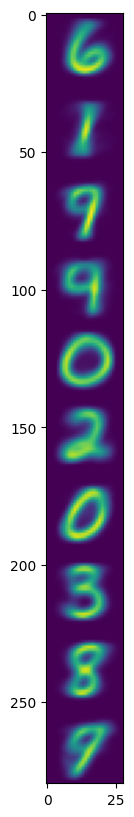

In [27]:
plt.figure(1, figsize=(20, 10))
img = means.cpu().view(num_means*28,28)
plt.imshow(img)